In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm 
import datetime as dt

Time period

In [52]:
Years = 10
enddate = dt.datetime.now()
startdate = enddate - dt. timedelta(days = 365*Years)

In [53]:
tickers = ['SPY','BND','GLD','QQQ']

Download daily adjusted close prices for these tickers

In [54]:
adj_close_df = pd.DataFrame() 
for ticker in tickers: 
    data = yf.download(ticker, start = startdate, end = enddate) 
    adj_close_df[ticker] = data['Close'] 
    
print(adj_close_df)


C:\Users\mannk\AppData\Local\Temp\ipykernel_6900\1710131183.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = startdate, end = enddate)
[*********************100%***********************]  1 of 1 completed
C:\Users\mannk\AppData\Local\Temp\ipykernel_6900\1710131183.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = startdate, end = enddate)
[*********************100%***********************]  1 of 1 completed
C:\Users\mannk\AppData\Local\Temp\ipykernel_6900\1710131183.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = startdate, end = enddate)
[*********************100%***********************]  1 of 1 completed
C:\Users\mannk\AppData\Local\Temp\ipykernel_6900\1710131183.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker,

                   SPY        BND         GLD         QQQ
Date                                                     
2015-12-21  171.428085  60.779785  103.150002  103.420265
2015-12-22  172.983749  60.697277  102.610001  104.100121
2015-12-23  175.125778  60.704857  102.309998  104.873085
2015-12-24  174.836792  60.749924  103.050003  104.854477
2015-12-28  174.437363  60.749924  102.269997  104.798607
...                ...        ...         ...         ...
2025-12-10  687.570007  74.260002  389.049988  627.609985
2025-12-11  689.169983  74.260002  393.239990  625.580017
2025-12-12  681.760010  74.029999  395.440002  613.619995
2025-12-15  680.729980  74.120003  395.799988  610.539978
2025-12-16  678.869995  74.260002  395.890015  611.750000

[2512 rows x 4 columns]


Calculate Daily log returns

In [55]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ
Date                                              
2015-12-22  0.009034 -0.001358 -0.005249  0.006552
2015-12-23  0.012307  0.000125 -0.002928  0.007398
2015-12-24 -0.001652  0.000742  0.007207 -0.000177
2015-12-28 -0.002287  0.000000 -0.007598 -0.000533
2015-12-29  0.010615 -0.003099 -0.000685  0.015607
...              ...       ...       ...       ...
2025-12-10  0.006610  0.002967  0.004250  0.004087
2025-12-11  0.002324  0.000000  0.010712 -0.003240
2025-12-12 -0.010810 -0.003102  0.005579 -0.019303
2025-12-15 -0.001512  0.001215  0.000910 -0.005032
2025-12-16 -0.002736  0.001887  0.000227  0.001980

[2511 rows x 4 columns]


Create an equally weighted portfolio

In [56]:
portfolio_value = 100000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.25 0.25 0.25 0.25]


Create historical poprtfolio returns

In [57]:
historical_returns = (log_returns * weights).sum(axis =1)
print(historical_returns)

Date
2015-12-22    0.002245
2015-12-23    0.004225
2015-12-24    0.001530
2015-12-28   -0.002605
2015-12-29    0.005610
                ...   
2025-12-10    0.004479
2025-12-11    0.002449
2025-12-12   -0.006909
2025-12-15   -0.001105
2025-12-16    0.000340
Length: 2511, dtype: float64


X day historical returns

In [58]:
days = 5

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
print(range_returns)

Date
2015-12-29    0.011005
2015-12-30    0.002959
2015-12-31   -0.006317
2016-01-04   -0.013322
2016-01-05   -0.009717
                ...   
2025-12-10    0.003803
2025-12-11    0.006611
2025-12-12   -0.001041
2025-12-15    0.000118
2025-12-16   -0.000746
Length: 2507, dtype: float64


specify confidence interval and calculate VAR using historical prices

In [59]:
confidence_interval = 0.95

VaR = -np.percentile(range_returns,100 - (confidence_interval * 100))*portfolio_value
print("VaR:", VaR)

VaR: 2208.5748585383185


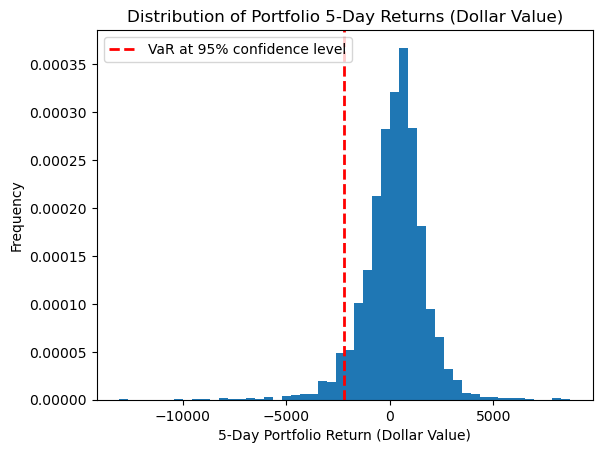

In [60]:
return_window = days
range_returns = historical_returns.rolling(window=return_window).sum()
range_returns = range_returns.dropna()

range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=50, density=True)
plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

Expected Shortfall

In [61]:
losses = -range_returns * portfolio_value


In [62]:
ES = losses[losses >= VaR].mean()

print(f"5-day VaR ({confidence_interval*100}%): {VaR:.2f}")
print(f"5-day Expected Shortfall ({confidence_interval*100}%): {ES:.2f}")

5-day VaR (95.0%): 2208.57
5-day Expected Shortfall (95.0%): 3533.98


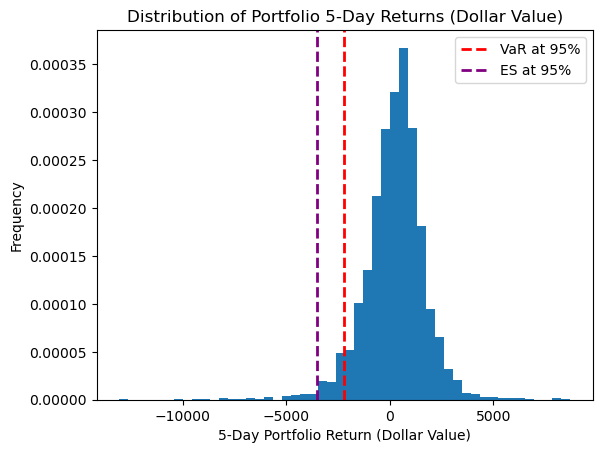

In [63]:
plt.hist(range_returns_dollar.dropna(), bins=50, density=True)

plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')

# VaR line
plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=2,
            label=f'VaR at {confidence_interval:.0%}')

# ES line
plt.axvline(-ES, color='purple', linestyle='dashed', linewidth=2,
            label=f'ES at {confidence_interval:.0%}')

plt.legend()
plt.show()


In [64]:
tail_losses = range_returns_dollar[range_returns_dollar <= -VaR]


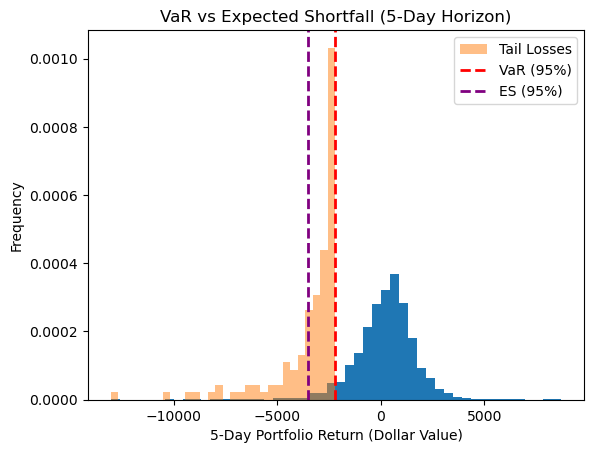

In [65]:
plt.hist(range_returns_dollar.dropna(), bins=50, density=True)

# Shade tail beyond VaR
plt.hist(tail_losses, bins=30, density=True, alpha=0.5, label='Tail Losses')

plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=2,
            label=f'VaR ({confidence_interval:.0%})')

plt.axvline(-ES, color='purple', linestyle='dashed', linewidth=2,
            label=f'ES ({confidence_interval:.0%})')

plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'VaR vs Expected Shortfall ({return_window}-Day Horizon)')
plt.legend()
plt.show()
